<a id="topL"></a>

# Working with the COS Line Spread Function

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Altering the extraction box used to extract your spectrum from a COS `TIME-TAG` exposure file.**
   #### 1. [**Investigating the exposure**](#invE)
   ##### - 1.1. [Getting the first glimpse of a 2D spectrum](#lookE)
   ##### - 1.2. [Defining some useful functions](#funE)
   ##### - 1.3. [Examining the extraction boxes](#boxE)

#### 2. [**Editing the extraction boxes**](#editE)
   ##### - 2.1. [Defining an editing function](#edfnE)
   ##### - 2.2. [Make the edits](#mkedE)
   ##### - 2.3. [Confirming the changes](#confE)
  
#### 3. [**Running the CalCOS Pipeline with the new XTRACTAB**](#calexE)
   ##### - 3.1. [Edit the XTRACTAB header value](#edhdrE)
   ##### - 3.2. [Run the pipeline](#runcE)


# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through convolving a template or high-resolution spectrum with the COS LSF. Note that at present, this notebook does not support working with NUV data.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `numpy` to handle arrays and functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `glob`, `os`, and `shutil` for working with system files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `matplotlib.pyplot` for plotting

These python packages are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

In [48]:
# for array manipulation
import numpy as np
# for reading fits files
from astropy.table import Table
from astropy.io import fits
# For downloading the data
from astroquery.mast import Observations as Obs
# Plotting
from matplotlib import pyplot as plt
# For dealing with system files
import glob, os, shutil
# For running the CalCOS pipeline
import calcos
# For comparing the old and new CalCOS values
from scipy.interpolate import interp1d 
# We will also suppress a warning that won't affect our data processing:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## We will also define a few directories we will need:

In [2]:
# These will be important directories for the notebook
datadir = './data/'
outputdir = './output/'
plotsdir = './output/plots/'

# Make the directories in case they don't exist
!mkdir ./output
!mkdir ./output/plots
!mkdir ./data

mkdir: ./output: File exists
mkdir: ./output/plots: File exists
mkdir: ./data: File exists


## And we will need to download the data we wish to work with:
We choose the exposures with the association obs_id: `LE4B04010` and download all the `_rawtag` data.
For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).
##### Note, we're working with the `_rawtags` because they are smaller files and quicker to download than the `_corrtag` files. However, this workflow translates very well to using `_corrtag` files, as you likely will want to do when working with your actual data.

In [3]:
pl = Obs.get_product_list(Obs.query_criteria(obs_id='LE4B04010'))
masked_pl = pl[np.isin(pl['productSubGroupDescription'],['RAWTAG', 'ASN', 'X1DSUM'])]
# Now download:
Obs.download_products(masked_pl)

INFO: Found cached file ./mastDownload/HST/le4b04010/le4b04010_x1dsum.fits with expected size 244800. [astroquery.query]


Local Path,Status,Message,URL
str50,str8,object,object
./mastDownload/HST/le4b04010/le4b04010_asn.fits,COMPLETE,None,None
./mastDownload/HST/le4b04010/le4b04010_x1dsum.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zfq/le4b04zfq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zkq/le4b04zkq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zoq/le4b04zoq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zqq/le4b04zqq_rawtag.fits,COMPLETE,None,None


We gather a list of all the `_rawtag` files we have downloaded, as well as the `_asnfile` and `_x1dsum` file:

In [4]:
rawtags = glob.glob('./mastDownload/HST/**/*_rawtag.fits', 
                    recursive=True)
asnfile = glob.glob('./mastDownload/HST/**/*_asn.fits', 
                    recursive=True)[0]
old_x1dsum = glob.glob('./mastDownload/HST/**/*_x1dsum.fits', 
                    recursive=True)[0]

<a id = invE></a>
# 1. Investigating the exposure

<a id = lookE></a>
## 1.1 Getting the first glimpse of a 2D spectrum

### We need to see where the NUV stripes fall in order to determine where we should place the extraction boxes.
#### We'll first plot this as a 2D image of the raw counts.
We grab and plot the raw counts data from the 0th rawtag file:

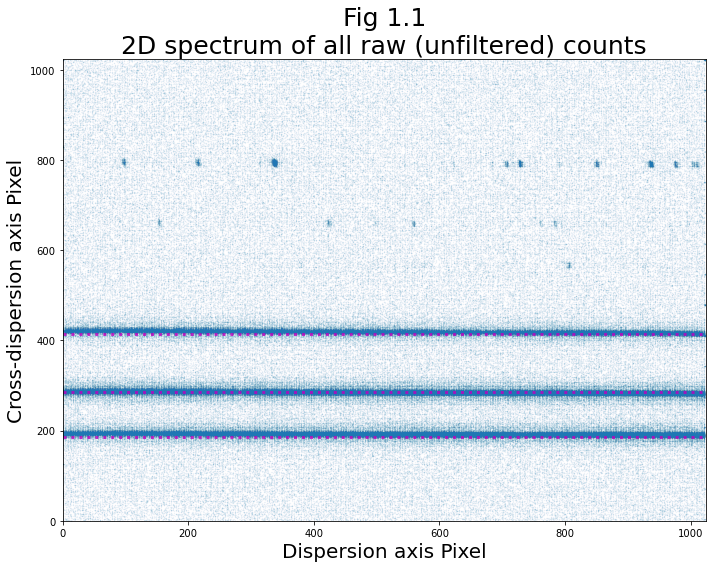

In [5]:
# Get the data from the first rawtag
rawtag = rawtags[0]
rtd = Table.read(rawtag,1)
###

plt.figure(figsize=(10,8))
plt.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')
for j in [187,285,415]: # Lines roughly centered on the 3 NUV stripes
    plt.axhline(j, color = 'm', linewidth = 3, alpha = 0.8, linestyle = 'dotted')

plt.xlim(0,1024)
plt.ylim(0,1024)

plt.xlabel('Dispersion axis Pixel', size = 20)
plt.ylabel('Cross-dispersion axis Pixel', size = 20)
plt.title("Fig 1.1\n2D spectrum of all raw (unfiltered) counts", size = 25)
plt.tight_layout()
plt.show()

### Now we'll need to see where the original `XTRACTAB` places its extraction boxes:
Find the name of the `XTRACTAB` used by this first `_rawtag` file:

In [6]:
orig_xtractab = fits.getheader(rawtag)['XTRACTAB']

### If you have an existing `lref` directory with a cache of reference files:
Give the system the `lref` system variable, which points to the reference file directory, uncomment the cell below (beginning with "`#### YES lref?`"), and comment out the following code cell (beginning with "`#### NO lref?`")

In [7]:
#### YES lref?

# lref = '/path/to/your/lref/'
# %env lref /path/to/your/lref/
# orig_xtractab = lref + orig_xtractab.split('$')[1] # This is the full path

### If you don't have an existing `lref` directory with a cache of reference files:

If you do not have a local copy of the reference files, (i.e. an lref directory,) you may, for the purposes of this notebook, download just the `XTRACTAB` using the cell below:

In [8]:
#### NO lref?

%env CRDS_PATH ./data
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env lref ./data/references/hst/cos/
lref = './data/references/hst/cos/'
! crds sync --files=w5g1439sl_1dx.fits

orig_xtractab = lref + orig_xtractab.split('$')[1] # This is the full path

env: CRDS_PATH=./data
env: CRDS_SERVER_URL=https://hst-crds.stsci.edu
env: lref=./data/references/hst/cos/
CRDS - INFO -  Symbolic context 'hst-operational' resolves to 'hst_0863.pmap'
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos



<a id = funE></a>
## 1.2 Defining some useful functions

We'll define a few functions to:
- Read in the data rows containing relevant extraction boxes from an XTRACTAB file
- Plot these extraction boxes over a spectrum 
  + *for clarity and signal to noise, we'll collapse this spectrum onto the y (cross-dispersion) axis*

### First, we'll write a function to read in the relavent extraction boxes from an XTRACTAB:

In [9]:
def readxtractab(xtractab, grat, cw, aper):

    """
    Reads in an XTRACTAB row of a particular COS mode and\
    gets extraction box sizes and locations.
    Inputs:
    xtractab (str) : path to xtractab file.
    raw (bool) : default False, meaning that the data is assumed to be corrtag.
    grat (string) : grating of relavent row (i.e. "G185M")
    cw (int or numerical) : cenwave of relavent row (i.e. (1786))
    aper (str) : aperture of relavent row (i.e. "PSA")
    
    """
    with fits.open(xtractab) as f:
        xtrdata = f[1].data # Get the fits data

    sel_nuva = np.where((xtrdata['segment'] == 'NUVA') & # Find NUVA 
                        (xtrdata['aperture'] == aper) & # of the right row
                        (xtrdata['opt_elem'] == grat) &
                        (xtrdata['cenwave'] == cw))

    sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') & # Now NUVB
                        (xtrdata['aperture'] == aper) &
                        (xtrdata['opt_elem'] == grat) &
                        (xtrdata['cenwave'] == cw))

    sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') & # Now NUVC
                        (xtrdata['aperture'] == aper) &
                        (xtrdata['opt_elem'] == grat) &
                        (xtrdata['cenwave'] == cw))

    hgta = xtrdata['HEIGHT'][sel_nuva][0] # get heights
    hgtb = xtrdata['HEIGHT'][sel_nuvb][0] #  of spec extract boxes
    hgtc = xtrdata['HEIGHT'][sel_nuvc][0]

    bspeca = xtrdata['B_SPEC'][sel_nuva][0] # y-intercept (b) of spec 
    bspecb = xtrdata['B_SPEC'][sel_nuvb][0] #  boxes
    bspecc = xtrdata['B_SPEC'][sel_nuvc][0]

    boundsa = [bspeca - hgta/2, bspeca + hgta/2] # determine y bounds of boxes 
    boundsb = [bspecb - hgtb/2, bspecb + hgtb/2]
    boundsc = [bspecc - hgtc/2, bspecc + hgtc/2]

    bkg1a = xtrdata['B_BKG1'][sel_nuva] # Do the same for the bkg extract boxes
    bkg2a = xtrdata['B_BKG2'][sel_nuva]
    bhgta = xtrdata['BHEIGHT'][sel_nuva]
    bkg1boundsa = [bkg1a - bhgta/2, bkg1a + bhgta/2]
    bkg2boundsa = [bkg2a - bhgta/2, bkg2a + bhgta/2]

    # the background locations are by default the same for all stripes

    return boundsa, boundsb, boundsc, bkg1boundsa, bkg2boundsa

# We'll note the returned values correspond to these extraction boxes
box_names = ['NUVA','NUVB','NUVC','BKG-1','BKG-2']

### We'll now need two functions in order to plot
The first function (`makeims()`) is a helper function for the second: `collapsey()`.

`collapsey()` takes a list of either `_rawtag` or `_corrtag` exposure files, as well as an `XTRACTAB` file, and creates a summary plot, with the 2D spectrum collapsed onto the y-axis.

In [10]:
def makeims(xarr, yarr):
    """
    Helper function for collapsey(): converts counts to image.
    """
    new_img = np.zeros((1024, 1024))
    xbin = np.asarray(np.floor((xarr + 0.5)), dtype=np.int)
    ybin = np.asarray(np.floor((yarr + 0.5)), dtype=np.int)
    # Add a count for each x,y pair
    for x, y in zip(xbin, ybin):
        try:
            new_img[y, x] += 1
        except IndexError:
            continue
    return new_img

### Collapse in y axis function

In [11]:
def collapsey(tagfiles, xtractab, raw = False, save = True, savename = False, fignum = False): # assumes corrtag, but will work with rawtag if raw=True
    """
    Takes a corrtag (default) or rawtag and makes a plot of the 2D spectrum collapsed to the y axis\
    i.e. summed over rows of pixels in the dispersion direction\
    then it overplots the extraction regions from a provided xtractab.
    
    Inputs:
    tagfiles (list of str) : list of rawtag or corrtag file paths.
    xtractab (str) : path to xtractab.
    raw (bool) : default False, meaning that the data is assumed to be corrtag.
    save (bool) : Do you want to save the image of the plot? Default True
    savename (str if specified) : name to save file as in plotsdir, if save == True.
    fignum  (str if specified) : Figure number to include in figtitle. Dafault is False.
    
    Outputs:
    yprof (numpy array of floats) : the 2D spectrum collapsed onto the y axis.
    """
    plt.figure(figsize=(12, 8))

    for numfile, myfile in enumerate(tagfiles): # go through all the tag files

        with fits.open(myfile) as f: # Grab data from file
            data = f[1].data
            h0 = f[0].header

        fppos = h0['FPPOS'] # get important header keys to determin row
        rootname = h0['ROOTNAME']
        target = h0['TARGNAME']
        grating = h0['OPT_ELEM']
        cenwave = h0['CENWAVE']
        
        if not raw: # grab corrected or raw time-tag points x and y locations
            xcorr = data['XCORR']
            ycorr = data['YCORR']

        elif raw:
            rawx = data['RAWX']
            rawy = data['RAWY']
            
        if raw: # call helper function on time tag data
            nuvim = makeims(rawx, rawy)
        else:
            nuvim = makeims(xcorr, ycorr)

        yprof = np.sum(nuvim, axis=1) # collapse onto the y axis

        # Make the main y-axis spectrum plot
        yaxis = np.arange(0, 1024)
        plt.plot(yprof, yaxis, label=f'{rootname} fppos = {fppos}')
        if numfile == 0: # Add in the plot formatting (just once - on the 0th file)
            if raw:
                plt.ylabel('RAWY Pixel', size = 18)
            else:
                plt.ylabel('YCORR Pixel', size = 18)

            plt.xlabel('Counts summed along X', size = 18)
            fig_title = f"Target: {target} spectrum;" +"\n"+f"XTRACTAB: {os.path.basename(xtractab)}"
            if fignum:
                fig_title = f"Fig {fignum}" + "\n" + fig_title
            plt.title(fig_title, fontsize = 23)
            psaboundsa, psaboundsb, psaboundsc, psabkg1, psabkg2 = readxtractab(xtractab, grating, cenwave, 'PSA')
            wcaboundsa, wcaboundsb, wcaboundsc, wcabkg1, wcabkg2 = readxtractab(xtractab, grating, cenwave, 'WCA')

            span = plt.axhspan(psaboundsa[0], psaboundsa[1], color='lightgray', label = 'PSA regions', alpha=0.7)
            plt.axhspan(psaboundsb[0], psaboundsb[1], color='lightgray', alpha=0.7)
            plt.axhspan(psaboundsc[0], psaboundsc[1], color='lightgray', alpha=0.7)

            span = plt.axhspan(psabkg1[0], psabkg1[1], color='lightblue', label = 'Background regions' , alpha=0.7)
            plt.axhspan(psabkg2[0], psabkg2[1], color='lightblue', alpha=0.7)
            span = plt.axhspan(wcaboundsa[0], wcaboundsa[1], color='lightgreen', label = 'WCA regions', alpha=0.7)
            plt.axhspan(wcaboundsb[0], wcaboundsb[1], color='lightgreen', alpha=0.7)
            plt.axhspan(wcaboundsc[0], wcaboundsc[1], color='lightgreen', alpha=0.7)
    
    plt.legend(loc = 'upper right')
    
    plt.tight_layout()
    
    ### Saving the figure:
    if save: # Do we want to save the image at all?
        if not savename: # Save in the default manner
            plt.savefig(plotsdir+f"{target}_regions.png", dpi = 200, bbox_inches = 'tight')
        elif savename: # Save with input savename
            plt.savefig(plotsdir+f"{savename}.png", dpi = 200, bbox_inches = 'tight')
    plt.show()
    plt.close()
    plt.clf()
    
    return yprof

<a id = boxE></a>
## 1.3. Examining the extraction boxes
### Now let's make a plot showing where these original `XTRACTAB` boxes fall on the raw count image:

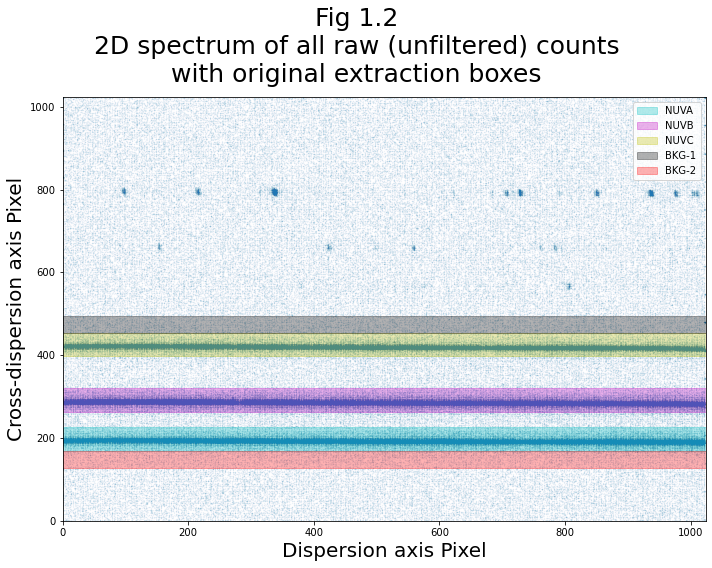

In [12]:
read_bounds = readxtractab(orig_xtractab, # bounds of all boxes...
                           grat='G185M', cw=1786, aper='PSA') # ...for these conditions

plt.figure(figsize=(10,8)) # Set up figure

plt.scatter(rtd['RAWX'],rtd['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0')

for i, (box, bname) in enumerate(zip(read_bounds, box_names)): # add all the boxes
    plt.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , label = bname)

plt.legend(loc = 'upper right') # Add plot formatting
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.xlabel('Dispersion axis Pixel', size = 20)
plt.ylabel('Cross-dispersion axis Pixel', size = 20)
plt.suptitle("Fig 1.2\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original extraction boxes", size = 25)
plt.tight_layout()
plt.savefig(plotsdir+'/2D_spec_orig_boxes.png', dpi = 200, bbox_inches = 'tight')

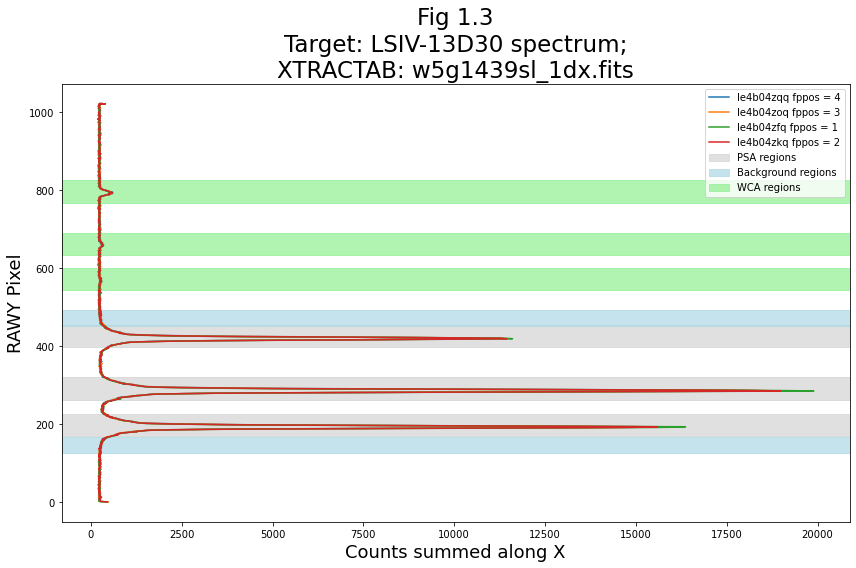

<Figure size 432x288 with 0 Axes>

In [13]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles = rawtags, xtractab = orig_xtractab, raw = True,
                      save = True, savename = "orig_xtractab_col_y", fignum = "1.3")

<a id = editE></a>
# 2. Editing the extraction boxes

#### Now that we know how to show the location of the extraction boxes, we can get to the actual editing.
##### We'll define another function to edit the existing XTRACTAB and save to a new file:

<a id = edfnE></a>
## 2.1. Defining an editing function

In [14]:
def edit_xtractab(xtractab, gratlist, cwlist, h_dict, b_dict, new_filename):

    """
    Function to actually edit the XTRACTAB itself\
    Change the height and y-intercepts of the extraction boxes,\
    and save to new XTRACTAB (1dx) file.
    Inputs:
    xtractab (str) : path to the XTRACTAB to edit
    gratlist (list of str) : all the gratings whose rows you would like to edit
    cwlist (list of str) : all the cenwave whose rows you would like to edit
    h_dict (dict of numerical) : heights of NUV A,B,C extraction boxes
    b_dict (dict) : dict of the y-intercepts - i.e. box center locations
    new_filename : filename/local path to new XTRACTAB file to create
    """
    
    f = fits.open(xtractab)

    xtrdata = f[1].data

    for grat in gratlist:

        for cw in cwlist:

            sel_nuva = np.where((xtrdata['segment'] == 'NUVA') &
                                (xtrdata['aperture'] == 'PSA') &
                                (xtrdata['opt_elem'] == grat) &
                                (xtrdata['cenwave'] == cw))

            sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') &
                                (xtrdata['aperture'] == 'PSA') &
                                (xtrdata['opt_elem'] == grat) &
                                (xtrdata['cenwave'] == cw))

            sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') &
                                (xtrdata['aperture'] == 'PSA') &
                                (xtrdata['opt_elem'] == grat) &
                                (xtrdata['cenwave'] == cw))

            # change the background region locations:

            xtrdata['B_BKG1'][sel_nuva] = intercept_dict['bbkg1']
            xtrdata['B_BKG2'][sel_nuva] = intercept_dict['bbkg2']

            xtrdata['B_BKG1'][sel_nuvb] = intercept_dict['bbkg1']
            xtrdata['B_BKG2'][sel_nuvb] = intercept_dict['bbkg2']

            xtrdata['B_BKG1'][sel_nuvc] = intercept_dict['bbkg1']
            xtrdata['B_BKG2'][sel_nuvc] = intercept_dict['bbkg2']

            # change the extraction heights

            xtrdata['HEIGHT'][sel_nuva] = h_dict['h_a']
            xtrdata['HEIGHT'][sel_nuvb] = h_dict['h_b']
            xtrdata['HEIGHT'][sel_nuvc] = h_dict['h_c']

            # change the B_SPEC

            xtrdata['B_SPEC'][sel_nuva] = intercept_dict['bspa']
            xtrdata['B_SPEC'][sel_nuvb] = intercept_dict['bspb']
            xtrdata['B_SPEC'][sel_nuvc] = intercept_dict['bspc']

    # save and close the file

    f.writeto(new_filename, overwrite=True)

    f.close()

    return

<a id = mkedE></a>
## 2.2. Make the edits

### Now we'll need to actually edit the XTRACTAB file to have different sizes and locations of the extraction boxes using `edit_xtractab()`.

For the purposes of this example, we'll **arbitrarily** set our y-intercepts and heights, just trying to roughly cover the NUV stripes, and show the different heights we can set the boxes to. *Note* that this function does not stop us from setting the boxes to overlap - but, dependent on your data, this may be a bad idea. The scope of this notebook is merely to explain *how* to alter the extraction boxes, not to determine the best box locations for any given dataset.

#### First we'll set up the values we'll edit the box parameters to, then run the function:

In [15]:
# These will be the values we set the box params to:
intercept_dict = {"bbkg1":900., "bbkg2":60., # centers of the background extract regions
                  'bspa':195., 'bspb':285., 'bspc':415.} # centers of NUV stripe extract regions
hgt_dict = {'h_a':40, 'h_b':50, 'h_c':60}

#Now edit using the edit_xtractab() function

edit_xtractab(xtractab=orig_xtractab, gratlist = ['G185M'], cwlist = [1786,1817], # data and rows to edit
              h_dict = hgt_dict, # new heights to set boxes to
              b_dict=intercept_dict, new_filename = './edit_1dx.fits') # new y-intercepts (y axis locations) for boxes

<a id = confE></a>
## 2.3. Confirming the changes

### Now let's plot the old and new extraction boxes side-by-side to compare:

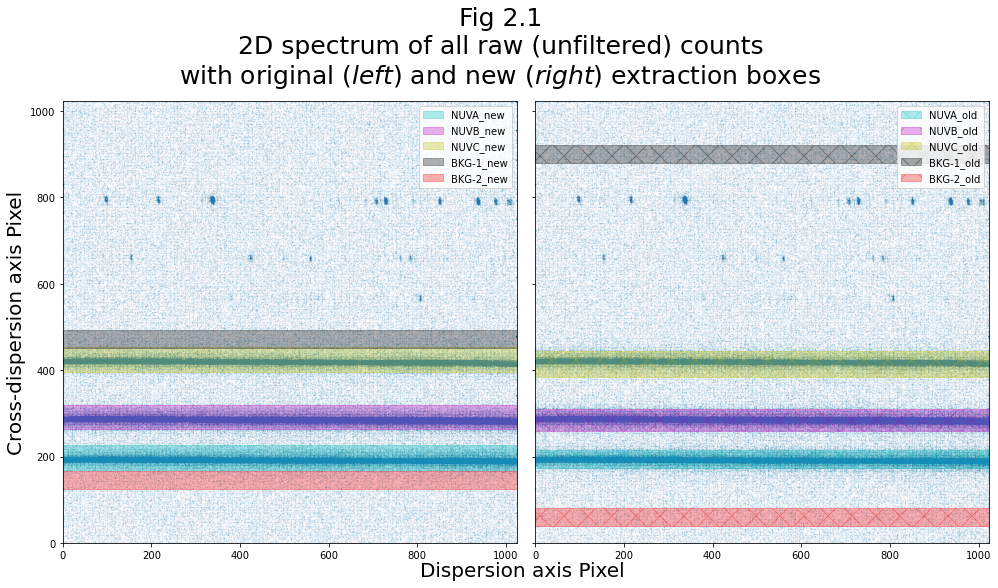

In [16]:
# Set up the plot
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,8), sharey=True)
# add raw count images
ax0.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')
ax1.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')

# First deal with the original XTRACTAB
read_bounds = readxtractab(orig_xtractab, grat='G185M', cw=1786, aper='PSA')
for i, box in enumerate(read_bounds): #plot each box
    ax0.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , label = box_names[i]+'_new')
# First deal with the newly edited XTRACTAB
read_bounds = readxtractab('./edit_1dx.fits', grat='G185M', cw=1786, aper='PSA')
for i, box in enumerate(read_bounds):
    ax1.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , hatch = 'x', label = box_names[i]+'_old')

    # Now some plot formatting
ax0.legend(loc = 'upper right')
ax1.legend(loc = 'upper right')

ax0.set_xlim(0,1024)
ax0.set_ylim(0,1024)
ax1.set_xlim(ax0.get_xlim())

fig.text(0.42,-.01,'Dispersion axis Pixel', size = 20)
ax0.set_ylabel('Cross-dispersion axis Pixel', size = 20)
plt.suptitle("Fig 2.1\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original ($left$) and new ($right$) extraction boxes", size = 25)
plt.tight_layout()
plt.savefig(plotsdir + '2D_spec_both_box_sets.png', dpi = 200, bbox_inches = 'tight')

### We'll also make a plot of the new boxes over the spectrum collapsed onto the y-axis:

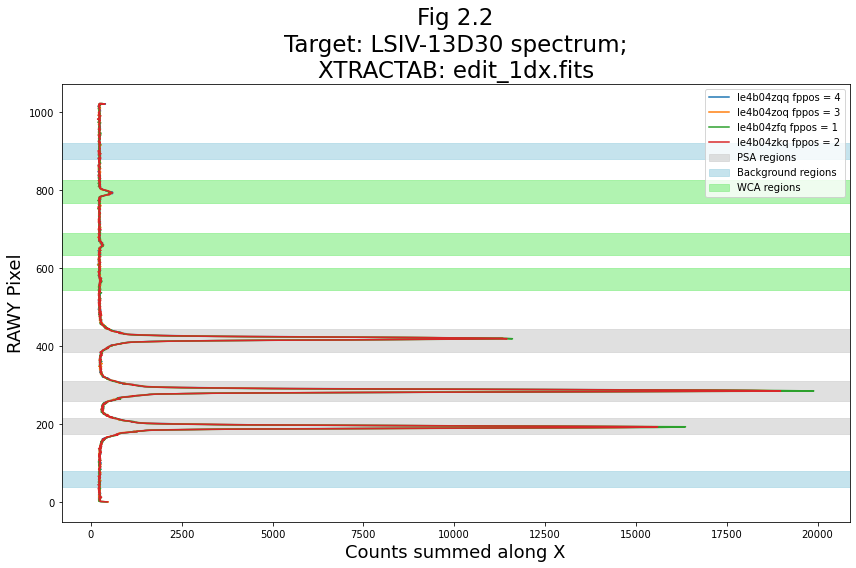

<Figure size 432x288 with 0 Axes>

In [17]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles = rawtags, xtractab = './edit_1dx.fits', raw = True,
                      save = True, savename = "edit_xtractab_col_y", fignum = "2.2")

<a id = calexE></a>
# 3. Running the CalCOS Pipeline with the new XTRACTAB

<a id = edhdrE></a>
## 3.2. Edit the XTRACTAB header value
More detailed information on changing header parameters can be found in our [walkthrough notebook on `CalCOS`](https://github.com/spacetelescope/COS-Notebooks/blob/master/CalCOS/CalCOS.ipynb).

Here, we just need to tell the pipeline to use our newly edited XTRACTAB. We do this by editing one of the header key values in all of the affected files.

In [18]:
try: 
    for rawtag in rawtags:
        os.rename(rawtag, datadir + os.path.basename(rawtag))
except FileNotFoundError:
    print ('No files')
try: 
    os.rename(asnfile, datadir + os.path.basename(asnfile))
except FileNotFoundError:
    print ('No files')
rawtags = glob.glob(datadir + '*rawtag*')
asnfile = glob.glob(datadir + '*asn*')[0]

In [19]:
for rawtag in rawtags:
    print("changing XTRACTAB for ", os.path.basename(rawtag))
    print("\tOriginally: ", fits.getheader(rawtag)['XTRACTAB'])
    fits.setval(filename=rawtag, keyword='XTRACTAB', value= './edit_1dx.fits' )
    print("\tNow set to: ", fits.getheader(rawtag)['XTRACTAB'])

changing XTRACTAB for  le4b04zqq_rawtag.fits
	Originally:  lref$w5g1439sl_1dx.fits
	Now set to:  ./edit_1dx.fits
changing XTRACTAB for  le4b04zoq_rawtag.fits
	Originally:  lref$w5g1439sl_1dx.fits
	Now set to:  ./edit_1dx.fits
changing XTRACTAB for  le4b04zfq_rawtag.fits
	Originally:  lref$w5g1439sl_1dx.fits
	Now set to:  ./edit_1dx.fits
changing XTRACTAB for  le4b04zkq_rawtag.fits
	Originally:  lref$w5g1439sl_1dx.fits
	Now set to:  ./edit_1dx.fits


<a id = runcE></a>
## 3.3. Run the pipeline
We will also largely gloss over the details of running the pipeline, `CalCOS`, in this notebook. Once again, much more detailed information on running the `CalCOS` pipeline can be found in our [walkthrough notebook on `CalCOS`](https://github.com/spacetelescope/COS-Notebooks/blob/master/CalCOS/CalCOS.ipynb).

*Note* you may get a "RuntimeWarning" when running the pipeline, but this is unlikely to be a problem. However you should certainly examine your data to make sure it seems reasonable.

In [21]:
# set up environment var to find all other ref files
%env lref /grp/hst/cdbs/lref/

env: lref=/grp/hst/cdbs/lref/


In [24]:
%%capture cap --no-stderr 
# Above, capture the output and save it in the next cell

# This line actually runs the pipeline:
calcos.calcos(asnfile, verbosity = 1, outdir = outputdir+"calcos_run1")

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/calcos/fpavg.py:1258: RuntimeWarning: divide by zero encountered in true_divide
  pqfactor = np.where(pqfactor == 0.0, 0.0, 1./pqfactor)


In [25]:
with open(outputdir+'output_calcos_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

### We'll finish up by plotting the new and original `x1dsum` spectra as extracted with the new and original extraction boxes:
*Note* that we can ignore the UnitsWarning.

Stripe NUVA differs by up to:     0.046%


Stripe NUVB differs by up to:     0.036%


Stripe NUVC differs by up to:     0.080%


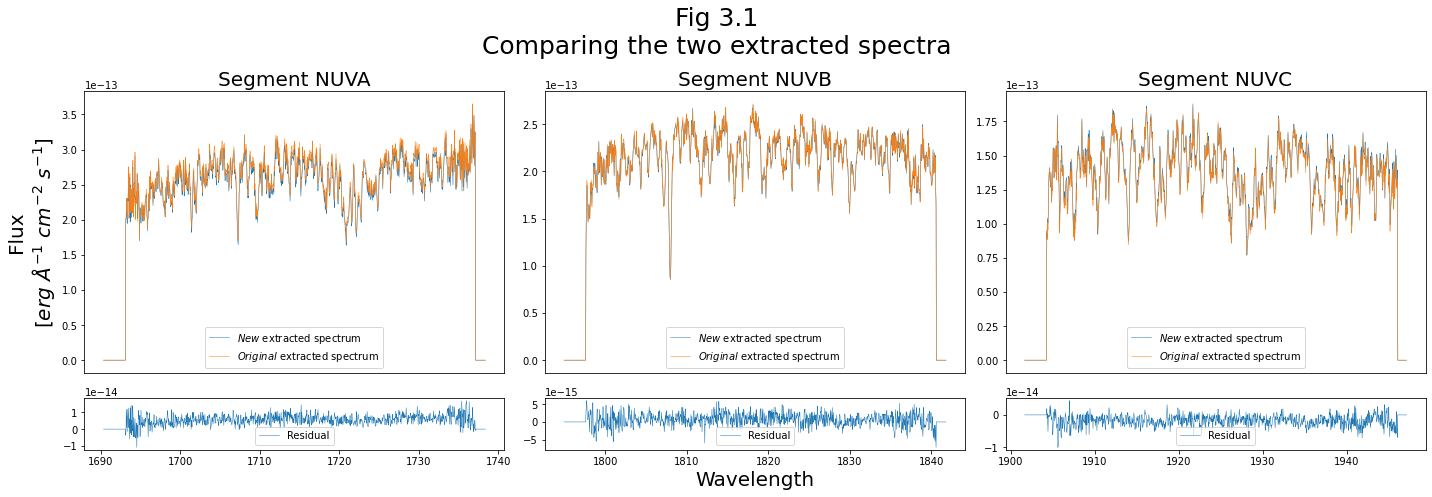

In [116]:
# Set up figure
fig = plt.figure(figsize = (20, 7))
gs = fig.add_gridspec(nrows = 5, ncols = 3) # Using gridspec to let us control panel sizes and locations

for i in range(3):
    ax0 = fig.add_subplot(gs[0:4,i])
    ax1 = fig.add_subplot(gs[4:5,i])
    new_wvln, new_flux = Table.read('./output/calcos_run1/le4b04010_x1dsum.fits')[i]['WAVELENGTH', 'FLUX']
    old_wvln, old_flux, seg = Table.read(old_x1dsum)[i]['WAVELENGTH', 'FLUX', 'SEGMENT']
    
    # Interpolate the new wvln onto the old wvln's sampling:
    new_flux_interp = interp1d(x = new_wvln, y = new_flux, fill_value="extrapolate")(old_wvln)

    # give max difference:
    print(f"Stripe {seg} differs by up to: \
    {max(new_flux - old_flux)/np.mean(abs(old_flux)):.3f}%")

    # Plotting - upper panel
    ax0.plot(new_wvln,new_flux, linewidth = .5, label = '$New$ extracted spectrum')
    ax0.plot(old_wvln,old_flux, linewidth = .5, label = '$Original$ extracted spectrum')
    # Plotting - lower panel
    ax1.plot(new_wvln,old_flux - new_flux_interp, linewidth = .5, label = 'Residual')
    # Some formatting:
    ax0.set_title(f"Segment {seg}", fontsize = 20)
    ax0.set_xticks([])
    ax0.legend(loc = 'lower center')
    ax1.legend(loc = 'lower center')
    if i == 0: # Add axis labels to the plot
        ax0.set_ylabel("Flux\n[$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", fontsize = 20)
    if i == 1:
        plt.xlabel("Wavelength", fontsize = 20)
plt.suptitle("Fig 3.1\nComparing the two extracted spectra", fontsize = 25)
plt.tight_layout()
plt.savefig(plotsdir+"comp_extracted.png", dpi = 200)

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).


---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Elaine Mae Frazer

**Updated On:** 2021-03-01

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topL)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>